In [13]:
import os
import json
import numpy as np
import cv2
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [14]:
# Step 1: Load the JSON data
with open('bcs_dataset_new.json', 'r') as f:
    data = json.load(f)
print(len(data))

97


[7.0, 6.0, 5.0, 5.0, 5.0, 6.0, 9.0, 6.0, 5.0, 4.0, 6.0, 4.0, 4.0, 5.0, 7.0, 4.0, 6.0, 4.0, 6.0, 3.0, 4.0, 5.0, 8.0, 3.0, 3.0, 3.0, 4.0, 3.0, 5.0, 5.0, 5.0, 6.0, 5.0, 5.0, 3.0, 3.0, 5.0, 6.0, 5.0, 5.0, 5.0, 6.0, 4.0, 3.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 3.0, 4.0, 3.0, 5.0, 5.0, 3.0, 7.0, 3.0, 5.0, 5.0, 9.0, 9.0, 5.0, 4.0, 6.0, 5.0, 2.0, 6.0, 4.0, 2.0, 5.0, 4.0, 5.0, 6.0, 5.0, 6.0, 3.0, 5.0, 5.0, 5.0, 4.0, 6.0, 5.0, 6.0, 5.0, 4.0, 6.0, 7.0, 5.0, 6.0, 6.0, 4.0, 5.0]
(array([ 2, 15, 15,  0, 36, 18,  0,  4,  1,  3]), array([2. , 2.7, 3.4, 4.1, 4.8, 5.5, 6.2, 6.9, 7.6, 8.3, 9. ]))


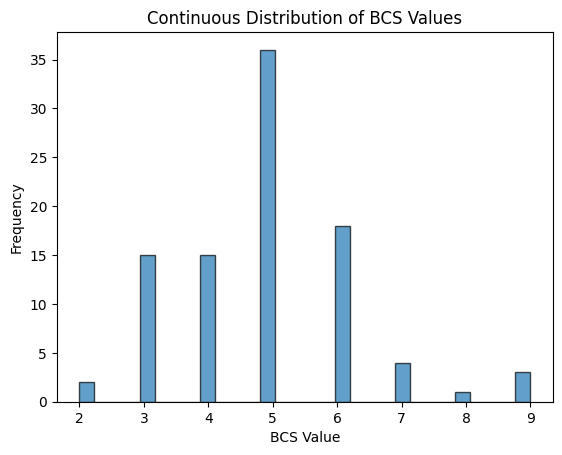

In [15]:
# Plot the distribution of BCS values
import matplotlib.pyplot as plt
bcs_values = [
    float(entry['BCS']) 
    for entry in data 
    if 'BCS' in entry and entry['BCS'] not in ['ไม่ระบุ (ไม่ทราบ)', '', None]
]
print(bcs_values)
plt.hist(bcs_values, bins=30, edgecolor='black', alpha=0.7)
print(np.histogram(bcs_values))
plt.xlabel('BCS Value')
plt.ylabel('Frequency')
plt.title('Continuous Distribution of BCS Values')
plt.show()

In [16]:
import json

# โหลด JSON
with open('bcs_dataset_new.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

total_entries = len(data)

# เช็ค entry ที่มี Top View
top_view_entries = [e for e in data if 'ภาพด้านบน (Top View)' in e and e['ภาพด้านบน (Top View)']]
num_top_view = len(top_view_entries)

# เช็ค entry ที่มี BCS valid
def is_valid_bcs(bcs_value):
    if bcs_value is None:
        return False
    if isinstance(bcs_value, str):
        bcs_value = bcs_value.strip()
        if bcs_value == '' or bcs_value == 'ไม่ระบุ (ไม่ทราบ)':
            return False
    return True

bcs_entries = [e for e in data if 'BCS' in e and is_valid_bcs(e['BCS'])]
num_bcs = len(bcs_entries)

# เช็ค entry ที่มีทั้ง Top View และ BCS valid
valid_entries = [e for e in data if 'ภาพด้านบน (Top View)' in e and e['ภาพด้านบน (Top View)']
                 and 'BCS' in e and is_valid_bcs(e['BCS'])]
num_valid = len(valid_entries)

print(f"Total entries in JSON: {total_entries}")
print(f"Entries with Top View image: {num_top_view}")
print(f"Entries with valid BCS: {num_bcs}")
print(f"Entries with both Top View & valid BCS: {num_valid}")


Total entries in JSON: 97
Entries with Top View image: 92
Entries with valid BCS: 94
Entries with both Top View & valid BCS: 89


In [17]:
# Preprocess image files to array
def preprocess_images(paths, target_size=(224, 224)):
    images = []
    for path in paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        images.append(img_array)
    return np.array(images)

In [18]:
import os
import cv2

images = []
bcs_labels = []

# เช็คว่าภาพหายหรือไม่
missing_images = []

for entry in data:
    # Check if all required keys exist and values are valid
    if (
        'ภาพด้านบน (Top View)' in entry and
        'BCS' in entry and
        entry['BCS'] not in ['ไม่ระบุ (ไม่ทราบ)', '', None]
    ):
        image_path = os.path.join('bcs_dataset', entry['ภาพด้านบน (Top View)'])
        
        if not os.path.exists(image_path):
            missing_images.append(entry['ภาพด้านบน (Top View)'])
            continue  # ข้าม entry ที่ไม่มีรูป
        
        # Read image
        img = cv2.imread(image_path)
        if img is None:
            print("Cannot read image:", image_path)
            continue  # ข้าม entry ที่อ่านไม่ได้
        
        # Resize and append
        img = cv2.resize(img, (528, 528))
        images.append(img)
        bcs_labels.append(float(entry['BCS']))

# สรุปผล
print(f"Total images loaded: {len(images)}")
print(f"Missing image files: {missing_images}")


Cannot read image: bcs_dataset/
Cannot read image: bcs_dataset/
Cannot read image: bcs_dataset/
Cannot read image: bcs_dataset/
Total images loaded: 88
Missing image files: ['https://drive.google.com/open?id=17fGn1AY3MkCPpx3am9eEKNgwfaefNpe9']


In [19]:
from collections import Counter# ======================================================
X = np.array(images, dtype="float32") / 255.0
y = np.array(bcs_labels, dtype="float32")

# Convert continuous BCS to integer classes
y_class = np.round(y).astype(int)

# Re-map classes to start from 0
unique_classes = np.unique(y_class)
class_to_idx = {c: i for i, c in enumerate(unique_classes)}
y_class = np.array([class_to_idx[c] for c in y_class])

print("Class mapping:", class_to_idx)
print("Unique mapped classes:", np.unique(y_class))
# Remove classes with < 2 samples
counts = Counter(y_class)
valid_idx = [i for i, label in enumerate(y_class) if counts[label] >= 2]
X = X[valid_idx]
y = y[valid_idx]
y_class = y_class[valid_idx]

print("Class distribution after filter:", Counter(y_class))

# ======================================================
# 4. Train/Val/Test Split
# ======================================================
X_train, X_test, y_train, y_test, y_class_train, y_class_test = train_test_split(
    X, y, y_class,
    test_size=0.2,
    stratify=y_class,
    random_state=42
)

X_train_final, X_val, y_train_final, y_val, y_class_train_final, y_class_val = train_test_split(
    X_train, y_train, y_class_train,
    test_size=0.2,
    stratify=y_class_train,
    random_state=42
)

print("Train:", X_train_final.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# ======================================================
# 5. Data Augmentation
# ======================================================
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(
    X_train_final, y_class_train_final,  # ✅ ใช้ class ที่ remap แล้ว
    batch_size=4,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val, y_class_val,  # ✅ ใช้ class ที่ remap แล้ว
    batch_size=4,
    shuffle=False
)


Class mapping: {2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7}
Unique mapped classes: [0 1 2 3 4 5 6 7]
Class distribution after filter: Counter({3: 34, 4: 18, 2: 14, 1: 13, 5: 4, 7: 3})
Train: (54, 528, 528, 3) Val: (14, 528, 528, 3) Test: (18, 528, 528, 3)


In [20]:
print(len(data))  # ลองดูว่ามีกี่ตัว
print("Train samples:", len(X_train))
print("Test samples:", len(X_test))

97
Train samples: 68
Test samples: 18


In [21]:
# Step 4: Build the model using MobileNet
base_model = EfficientNetB6(weights='imagenet', include_top=True, input_shape=(528,528,3))

In [22]:
# Freeze the layers of the base model
base_model.trainable = True

x = base_model.output
# x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(9, activation='softmax')(x)  # 9 classes (1-9 BCS)

In [23]:
# Create the model
model = Model(inputs=base_model.input, outputs=predictions)


In [24]:

# Step 5: Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',  # Sparse categorical cross-entropy for integer labels
              metrics=['accuracy'])


In [25]:
from tensorflow.keras.callbacks import EarlyStopping
import time
start_time = time.time()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=50,                  # epoch เพิ่มได้เพราะ generator
    validation_data=val_generator,
    callbacks=[early_stopping]
)

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")

Epoch 1/50


/Users/mjrchy/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 163s 8s/step - accuracy: 0.1261 - loss: 2.1968 - val_accuracy: 0.2143 - val_loss: 2.1940
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 105s 7s/step - accuracy: 0.4202 - loss: 2.1895 - val_accuracy: 0.3571 - val_loss: 2.1889
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 104s 7s/step - accuracy: 0.3483 - loss: 2.1836 - val_accuracy: 0.3571 - val_loss: 2.1834
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 107s 8s/step - accuracy: 0.3984 - loss: 2.1738 - val_accuracy: 0.3571 - val_loss: 2.1777
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 117s 8s/step - accuracy: 0.3994 - loss: 2.1615 - val_accuracy: 0.3571 - val_loss: 2.1721
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 119s 9s/step - accuracy: 0.4164 - loss: 2.1488 - val_accuracy: 0.3571 - val_loss: 2.1665
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 106s 8s/step - accuracy: 0.4631 - loss: 2.1293 - val_accuracy: 0.3571 - val_loss: 2.1606
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 123s 9s/step - accuracy: 0.5178 - loss: 2.1151 - val_accuracy: 0.3571 - val_loss: 2.

In [29]:
# Evaluate model
import time
start_time = time.time()
loss, accuracy = model.evaluate(X_test, y_test)
end_time = time.time()

total_time = end_time - start_time
# Per image inference time
num_images = len(X_test)
time_per_image = total_time / num_images

print(f"Inference completed in {total_time:.2f} seconds for {num_images} images.")
print(f"Average inference time per image: {time_per_image * 1000:.2f} ms")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 528, 528, 3)

In [27]:
import numpy as np
from collections import Counter

# After you split the data
print("✅ Test set BCS distribution:")
bcs_counts = Counter(y_test)
for bcs, count in sorted(bcs_counts.items()):
    print(f"BCS {bcs}: {count} samples")

print(f"\nTotal: {len(y_test)} test samples")


✅ Test set BCS distribution:
BCS 3.0: 3 samples
BCS 4.0: 3 samples
BCS 5.0: 7 samples
BCS 6.0: 4 samples
BCS 7.0: 1 samples

Total: 18 test samples


In [28]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model
model = load_model('bcs_prediction_model.h5')

# Predict class probabilities
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Adjust labels if you trained using BCS values 1–9
y_test_adj = y_test # Only if labels were originally 1-9

# Define all BCS class labels (0–8 representing BCS 1–9)
all_labels = list(range(9))

# Create confusion matrix with all 9 classes
cm = confusion_matrix(y_test_adj, y_pred, labels=all_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'BCS {i}' for i in range(1, 10)],
            yticklabels=[f'BCS {i}' for i in range(1, 10)])
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('Confusion Matrix for BCS Scores')
plt.show()

# Print classification report (force inclusion of all labels)
print("\nClassification Report:")
print(classification_report(
    y_test_adj, y_pred,
    labels=all_labels,
    target_names=[f'{i}' for i in range(1, 10)],
    zero_division=0  # Prevent errors if a class is missing
))


ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(18, 528, 528, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


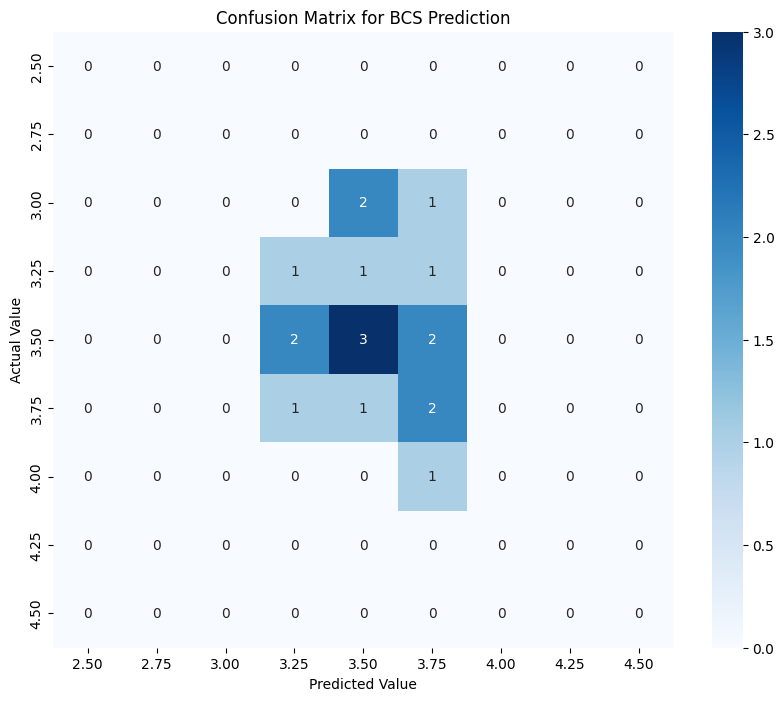


Classification Report:
              precision    recall  f1-score   support

        2.50       0.00      0.00      0.00         0
        2.75       0.00      0.00      0.00         0
        3.00       0.00      0.00      0.00         3
        3.25       0.25      0.33      0.29         3
        3.50       0.43      0.43      0.43         7
        3.75       0.25      0.50      0.33         4
        4.00       0.00      0.00      0.00         1
        4.25       0.00      0.00      0.00         0
        4.50       0.00      0.00      0.00         0

   micro avg       0.32      0.33      0.32        18
   macro avg       0.10      0.14      0.12        18
weighted avg       0.26      0.33      0.29        18



In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model
model = load_model('bcs_prediction_model.h5')

# Predict class probabilities
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Adjust labels if you trained using BCS values 2.50, 2.75, ..., 4.50
y_test_adj = y_test  # Adjust this if necessary

# Define the new BCS class labels
class_labels = [2.50, 2.75, 3.00, 3.25, 3.50, 3.75, 4.00, 4.25, 4.50]

# Map the predicted indices to the corresponding BCS values
y_pred_adjusted = [class_labels[i] for i in y_pred]

# Map the true indices to the corresponding BCS values
y_test_adjusted = [class_labels[i] for i in y_test_adj]

# Convert the continuous BCS values to their respective class indices
bins = np.linspace(2.50, 4.50, len(class_labels) + 1)  # Define bins for BCS classes
y_true_binned = np.digitize(y_test_adjusted, bins) - 1  # Bin true labels
y_pred_binned = np.digitize(y_pred_adjusted, bins) - 1  # Bin predicted labels

# Create confusion matrix with the new BCS class labels (as indices)
cm = confusion_matrix(y_true_binned, y_pred_binned, labels=range(len(class_labels)))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'{i:.2f}' for i in class_labels],
            yticklabels=[f'{i:.2f}' for i in class_labels])
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('Confusion Matrix for BCS Prediction')
plt.show()

# Print classification report (force inclusion of all labels)
print("\nClassification Report:")
print(classification_report(
    y_true_binned, y_pred_binned,
    labels=range(len(class_labels)),
    target_names=[f'{i:.2f}' for i in class_labels],
    zero_division=0  # Prevent errors if a class is missing
))
